# Autor: Grover Limachi
Aplique todas las tecnicas y estrategias de regularizacion a sus modelos desarrollados en la practica 
Dataset de vinos

Información sobre atributos: Variables de entrada (basadas en pruebas fisicoquímicas): 
1. acidez fija 
2. acidez volátil 
3. ácido cítrico 
4. azúcar residual
5. cloruros
6. dióxido de azufre libre
7. dióxido de azufre total
8. densidad
9. pH 
10. sulfatos 
11. alcohol Variable de salida (basada en datos sensoriales): 
12. calidad (puntuación entre 0 y 10)

In [1]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls
%mkdir data
!ls
import sys

sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/SIS330/reseta/data')
sys.path.insert(1, '/content/gdrive/MyDrive/Colab Notebooks/SIS330/reseta')


ckpt.pt  data  gdrive  sample_data
mkdir: cannot create directory ‘data’: File exists
ckpt.pt  data  gdrive  sample_data


In [4]:
import shutil

shutil.copy("/content/gdrive/MyDrive/Colab Notebooks/SIS330/reseta/vinoWhite.csv","/content/data/vino1.csv")
shutil.copy("/content/gdrive/MyDrive/Colab Notebooks/SIS330/reseta/vinoRed.csv","/content/data/vino2.csv")
# shutil.copy("/content/gdrive/MyDrive/Colab Notebooks/SIS421/Laboratorios/Laboratorio 3/glass.csv","/content/data/glass.csv")

'/content/data/vino2.csv'

In [5]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def evaluate(x):
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

In [6]:
# clase Dataset, hereda de la clase `torch.utils.data.Dataset`
class Dataset(torch.utils.data.Dataset):
    # constructor
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float().cuda()
        self.Y = torch.from_numpy(Y).long().cuda()
    # devolvemos el número de datos en el dataset
    def __len__(self):
        return len(self.X)
    # devolvemos el elemento `ix` del dataset
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

In [7]:
data = np.loadtxt('/content/data/vino2.csv', dtype=np.float32, delimiter=',')
# print(data.shape)
X, Y = data[:, :11], data[:,11]
# print(X[0], Y[0])
Y = np.array([int(e) for e in Y])
Y = np.squeeze(Y)
# print(y_train)

trainPorcen = int(len(data)/100*70)+2
testPorcen = int(len(data)/100*20)
valPorcen = int(len(data)/100*10)
print(trainPorcen, testPorcen, valPorcen)

X_train = X[:trainPorcen, :11]
y_train = Y[:trainPorcen]

X_test = X[trainPorcen:trainPorcen + testPorcen, :11]
y_test = Y[trainPorcen:trainPorcen + testPorcen]

X_val = X[trainPorcen + testPorcen:, :11]
y_val = Y[trainPorcen + testPorcen:]

# dataset = Dataset(X_train,y_train)
# len(dataset)
print(trainPorcen, trainPorcen + testPorcen, trainPorcen + testPorcen + valPorcen)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

# print(X_train[0:])
# print(X_train[:5], y_train[:5])
# print(X_test[0:])
# print(X_test[:5], y_test[:5])
# print(X_val[0:])

1121 319 159
1121 1440 1599
(1121, 11) (1121,)
(319, 11) (319,)
(159, 11) (159,)


In [8]:
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=10, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=10, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(1121, 159)

In [9]:
def build_model(D_in=11, H=12, D_out=11):
    model = torch.nn.Sequential(
      torch.nn.Linear(D_in, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, D_out),
    ).cuda()
    return model

def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            # print(y_pred, y_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [10]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/100 loss 1.19514 acc 0.42920 val_loss 1.32278 val_acc 0.40764
Epoch 20/100 loss 1.19236 acc 0.42920 val_loss 1.28059 val_acc 0.40764
Epoch 30/100 loss 1.18918 acc 0.42478 val_loss 1.28677 val_acc 0.40764
Epoch 40/100 loss 1.18962 acc 0.40088 val_loss 1.23147 val_acc 0.42986
Epoch 50/100 loss 1.19788 acc 0.42566 val_loss 1.24932 val_acc 0.42986
Epoch 60/100 loss 1.19873 acc 0.41327 val_loss 1.26302 val_acc 0.40764
Epoch 70/100 loss 1.18802 acc 0.43274 val_loss 1.23009 val_acc 0.42986
Epoch 80/100 loss 1.18640 acc 0.41770 val_loss 1.26941 val_acc 0.40764
Epoch 90/100 loss 1.18794 acc 0.42212 val_loss 1.22938 val_acc 0.40764
Epoch 100/100 loss 1.18835 acc 0.41770 val_loss 1.26269 val_acc 0.40764


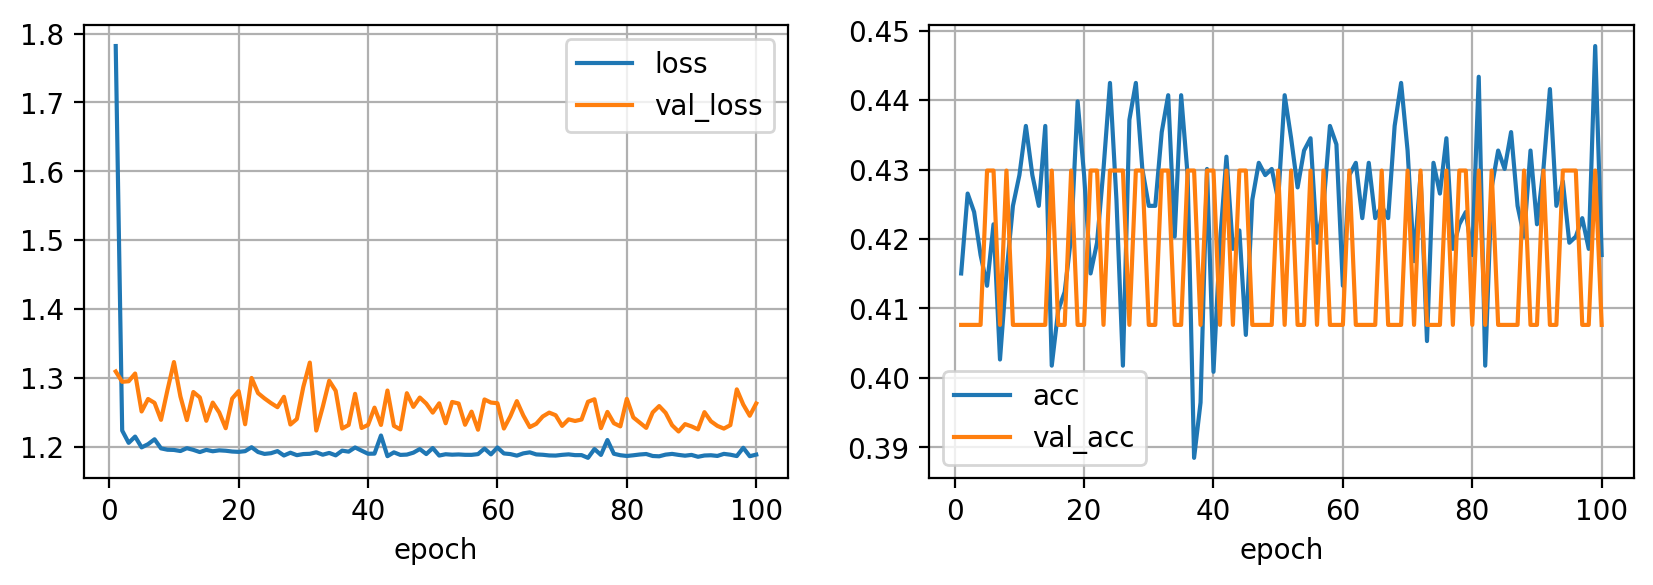

In [11]:
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [12]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.3824451410658307

# Regularizacion L2

In [13]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.01)

Epoch 10/100 loss 1.18093 acc 0.45841 val_loss 1.40404 val_acc 0.42986
Epoch 20/100 loss 1.17460 acc 0.48496 val_loss 1.32275 val_acc 0.33125
Epoch 30/100 loss 1.17938 acc 0.48673 val_loss 1.21604 val_acc 0.45139
Epoch 40/100 loss 1.19726 acc 0.43451 val_loss 1.28376 val_acc 0.41389
Epoch 50/100 loss 1.16909 acc 0.46549 val_loss 1.54852 val_acc 0.45486
Epoch 60/100 loss 1.18490 acc 0.47788 val_loss 1.26865 val_acc 0.40764
Epoch 70/100 loss 1.17982 acc 0.44336 val_loss 1.26711 val_acc 0.46111
Epoch 80/100 loss 1.17218 acc 0.49558 val_loss 1.26599 val_acc 0.44167
Epoch 90/100 loss 1.20797 acc 0.41150 val_loss 1.25270 val_acc 0.42986
Epoch 100/100 loss 1.20714 acc 0.41858 val_loss 1.26711 val_acc 0.42986


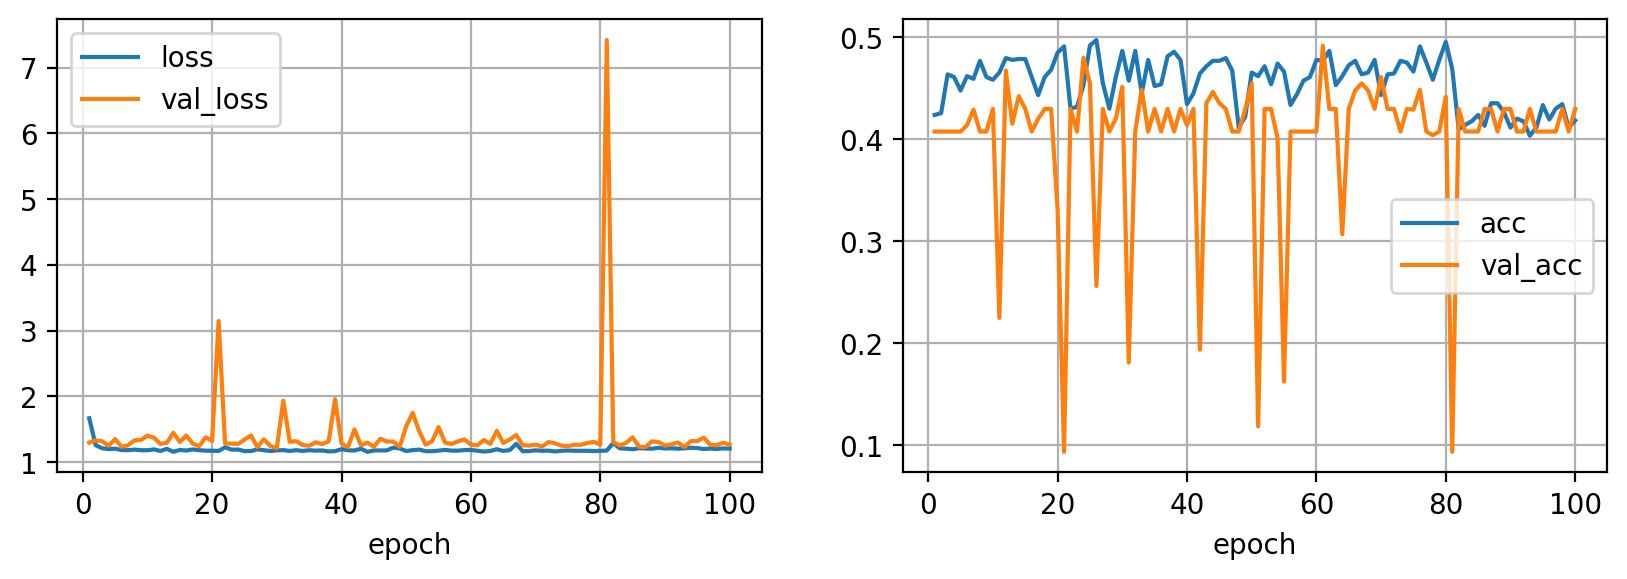

In [14]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [15]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.4702194357366771

# Early Stopping

In [16]:
def fit(model, dataloader, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [17]:
model = build_model()
hist = fit(model, dataloader, early_stopping=20)

Mejor modelo guardado con acc 0.42986 en epoch 1
Epoch 10/100 loss 1.21835 acc 0.41947 val_loss 1.24887 val_acc 0.42986
Epoch 20/100 loss 1.19102 acc 0.43274 val_loss 1.29193 val_acc 0.40764
Entrenamiento detenido en epoch 21 por no mejorar en 20 epochs seguidas


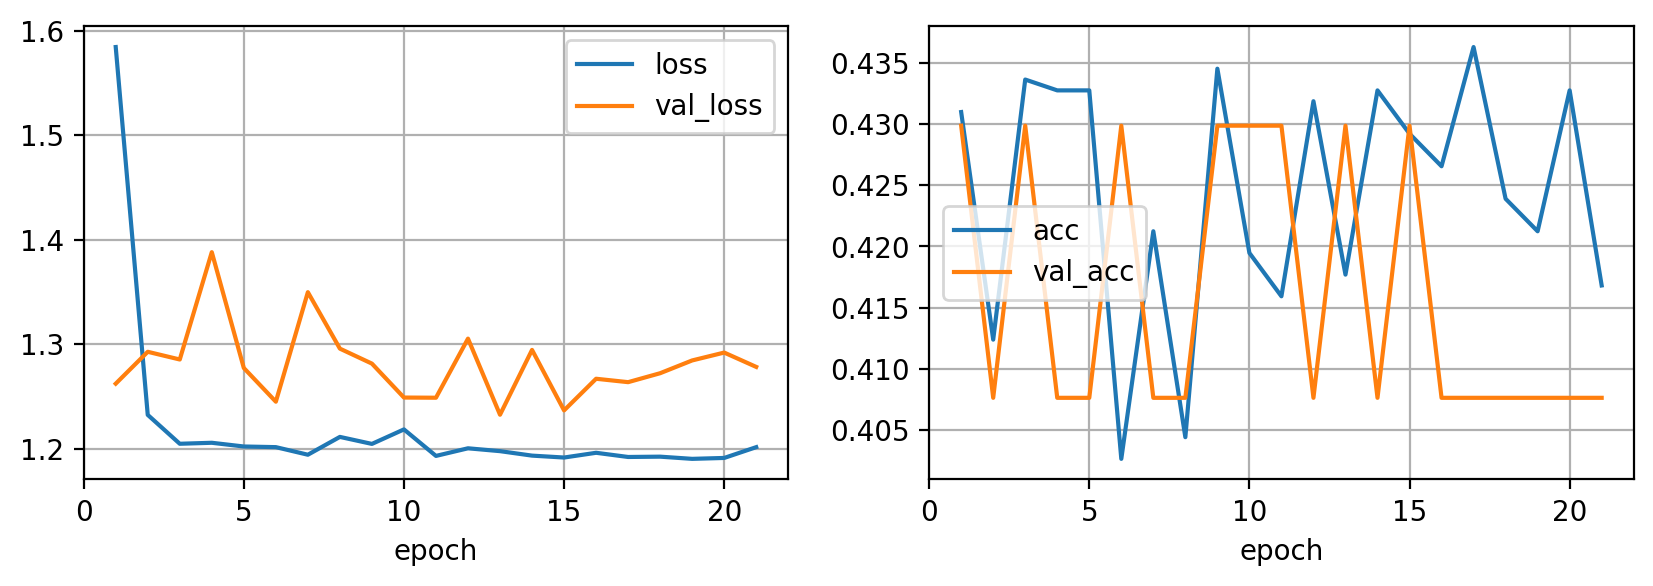

In [18]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [19]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.4702194357366771

# Dropout

In [22]:
def build_model(D_in=11, H=12, D_out=10, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    ).cuda()

In [23]:
model = build_model(p=0.5)
hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.42986 en epoch 1
Epoch 10/100 loss 1.20746 acc 0.41947 val_loss 1.26489 val_acc 0.40764
Epoch 20/100 loss 1.22685 acc 0.42655 val_loss 1.23120 val_acc 0.40764
Epoch 30/100 loss 1.18843 acc 0.41150 val_loss 1.23546 val_acc 0.40764
Epoch 40/100 loss 1.18973 acc 0.43451 val_loss 1.24054 val_acc 0.40764
Epoch 50/100 loss 1.21976 acc 0.42301 val_loss 1.23345 val_acc 0.40764
Epoch 60/100 loss 1.18763 acc 0.43363 val_loss 1.22916 val_acc 0.42986
Epoch 70/100 loss 1.18551 acc 0.43097 val_loss 1.24566 val_acc 0.40764
Epoch 80/100 loss 1.19455 acc 0.43451 val_loss 1.25022 val_acc 0.40764
Epoch 90/100 loss 1.18407 acc 0.41681 val_loss 1.24534 val_acc 0.40764
Epoch 100/100 loss 1.18605 acc 0.42832 val_loss 1.24163 val_acc 0.40764


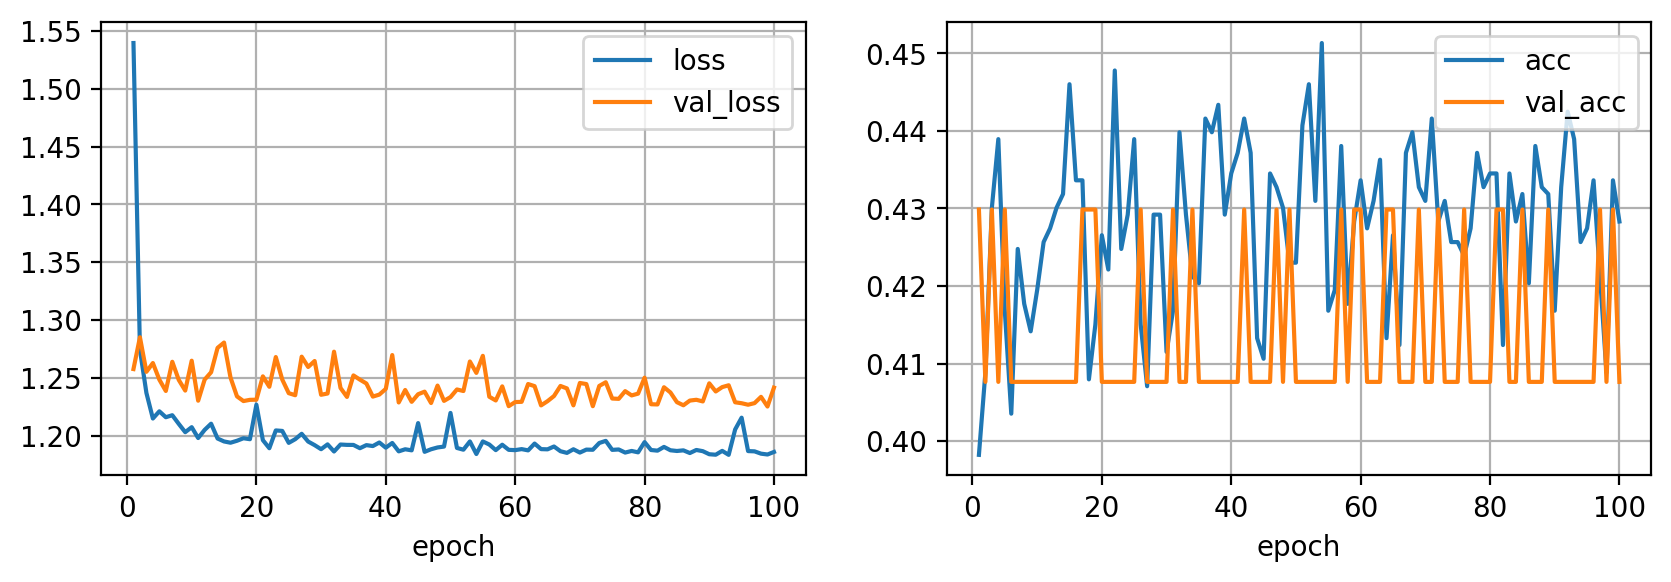

In [24]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [27]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())
# accuracy_score(y_test, y_pred.numpy())

0.4702194357366771

# Usar mas datos

In [28]:
data1 = np.genfromtxt('/content/data/vino2.csv',delimiter=',')
data2 = np.genfromtxt('/content/data/vino1.csv',delimiter=',')
# print(data.shape)
dataAument = np.concatenate((data1, data2))
X, Y = dataAument[:, :11], dataAument[:,11]
# print(X)
# Y = np.array([int(e) for e in Y])
# Y = np.squeeze(Y)
# print(y_train)

trainPorcen = int(len(dataAument)/100*70) + 2
testPorcen = int(len(dataAument)/100*20)
valPorcen = int(len(dataAument)/100*10)
print(trainPorcen, testPorcen, valPorcen)

X_train = X[:trainPorcen, :11]
y_train = Y[:trainPorcen]

X_test = X[trainPorcen:trainPorcen + testPorcen, :11]
y_test = Y[trainPorcen:trainPorcen + testPorcen]

X_val = X[trainPorcen + testPorcen:, :11]
y_val = Y[trainPorcen + testPorcen:]

dataset = Dataset(X_train,y_train)
len(dataset)
print(trainPorcen, trainPorcen + testPorcen, trainPorcen + testPorcen + valPorcen)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

4549 1299 649
4549 5848 6497
(4549, 11) (4549,)
(1299, 11) (1299,)
(649, 11) (649,)


In [29]:
dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=10, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=10, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(4549, 649)

In [30]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.55179 en epoch 1
Epoch 10/100 loss 1.28917 acc 0.40249 val_loss 1.20353 val_acc 0.55179
Entrenamiento detenido en epoch 11 por no mejorar en 10 epochs seguidas


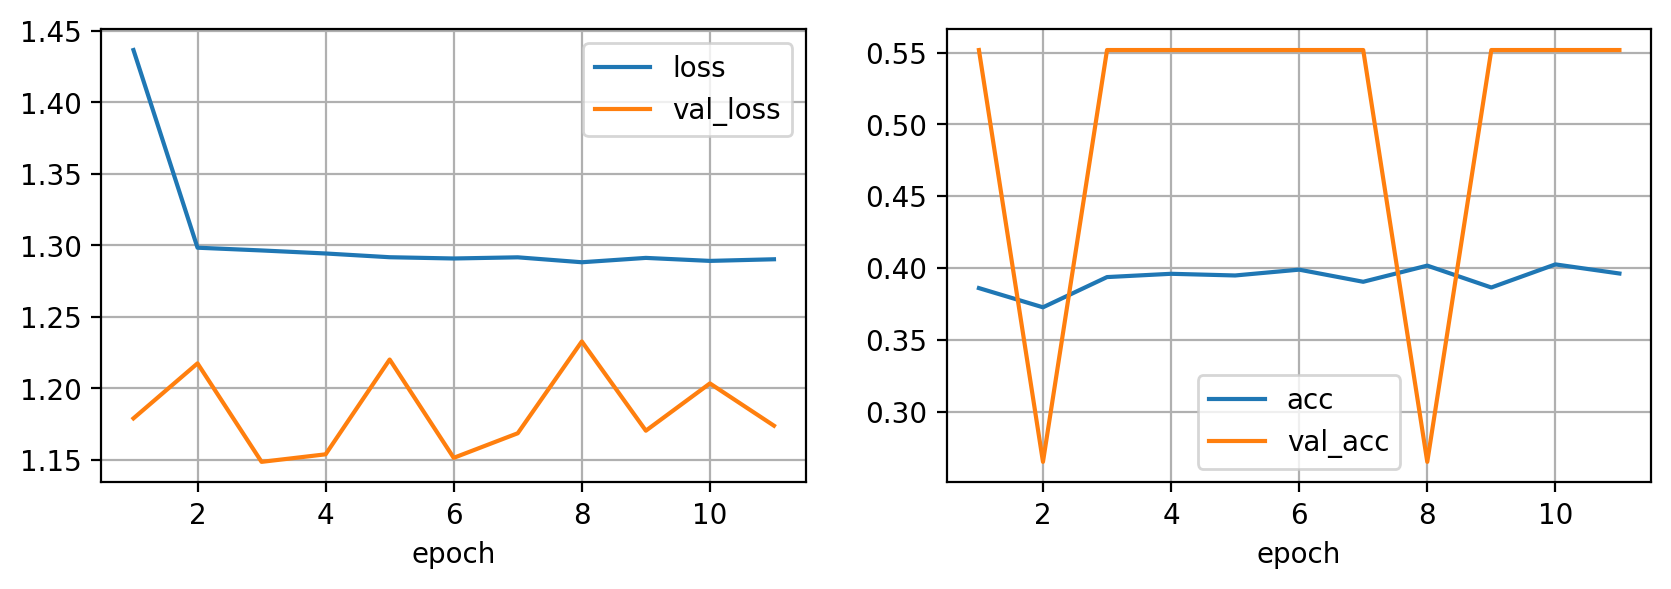

In [32]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

In [31]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.46882217090069284

# Optimizacion

In [33]:
def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

## SGD

In [34]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.42034 en epoch 1
Mejor modelo guardado con acc 0.55179 en epoch 2
Mejor modelo guardado con acc 0.55949 en epoch 5
Mejor modelo guardado con acc 0.56410 en epoch 10
Epoch 10/100 loss 1.28278 acc 0.42186 val_loss 1.18573 val_acc 0.56410
Mejor modelo guardado con acc 0.56718 en epoch 11
Epoch 20/100 loss 1.27055 acc 0.43263 val_loss 1.14489 val_acc 0.55641
Epoch 30/100 loss 1.26089 acc 0.43658 val_loss 1.11440 val_acc 0.56103
Mejor modelo guardado con acc 0.57179 en epoch 37
Epoch 40/100 loss 1.24970 acc 0.44061 val_loss 1.12430 val_acc 0.55641
Epoch 50/100 loss 1.24024 acc 0.44137 val_loss 1.10417 val_acc 0.53795
Mejor modelo guardado con acc 0.57641 en epoch 53
Mejor modelo guardado con acc 0.57966 en epoch 58
Epoch 60/100 loss 1.22349 acc 0.45179 val_loss 1.05473 val_acc 0.56564
Epoch 70/100 loss 1.22030 acc 0.45116 val_loss 1.08899 val_acc 0.57026
Mejor modelo guardado con acc 0.58120 en epoch 71
Mejor modelo guardado con acc 0.58256 en epoch 76
Mejor 

In [35]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_momentum = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.55179 en epoch 1
Mejor modelo guardado con acc 0.55641 en epoch 2
Mejor modelo guardado con acc 0.57641 en epoch 9
Epoch 10/100 loss 1.27886 acc 0.40667 val_loss 1.16147 val_acc 0.54564
Epoch 20/100 loss 1.26530 acc 0.41067 val_loss 1.15300 val_acc 0.53009
Epoch 30/100 loss 1.24882 acc 0.41963 val_loss 1.07224 val_acc 0.55333
Epoch 40/100 loss 1.24684 acc 0.43399 val_loss 1.12612 val_acc 0.48051
Epoch 50/100 loss 1.22309 acc 0.43639 val_loss 1.03301 val_acc 0.55026
Mejor modelo guardado con acc 0.58120 en epoch 59
Epoch 60/100 loss 1.21416 acc 0.45477 val_loss 1.13466 val_acc 0.48376
Epoch 70/100 loss 1.21308 acc 0.44383 val_loss 1.05830 val_acc 0.52564
Mejor modelo guardado con acc 0.58889 en epoch 73
Epoch 80/100 loss 1.19858 acc 0.46032 val_loss 1.21951 val_acc 0.36376
Epoch 90/100 loss 1.21851 acc 0.45482 val_loss 1.05790 val_acc 0.53795
Epoch 100/100 loss 1.20730 acc 0.46029 val_loss 1.05511 val_acc 0.56274


In [36]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.48872 en epoch 1
Mejor modelo guardado con acc 0.53641 en epoch 3
Mejor modelo guardado con acc 0.57949 en epoch 5
Mejor modelo guardado con acc 0.58427 en epoch 8
Epoch 10/100 loss 1.18719 acc 0.47658 val_loss 1.09374 val_acc 0.55641
Mejor modelo guardado con acc 0.60120 en epoch 13
Epoch 20/100 loss 1.12007 acc 0.50474 val_loss 1.11582 val_acc 0.52376
Epoch 30/100 loss 1.10537 acc 0.51683 val_loss 1.16049 val_acc 0.48974
Epoch 40/100 loss 1.09273 acc 0.52276 val_loss 1.19140 val_acc 0.45880
Epoch 50/100 loss 1.08660 acc 0.53175 val_loss 1.23155 val_acc 0.44513
Epoch 60/100 loss 1.08234 acc 0.52608 val_loss 1.06443 val_acc 0.50068
Epoch 70/100 loss 1.07871 acc 0.53038 val_loss 1.04785 val_acc 0.47299
Epoch 80/100 loss 1.07047 acc 0.53038 val_loss 1.06076 val_acc 0.51487
Epoch 90/100 loss 1.06789 acc 0.53614 val_loss 1.03048 val_acc 0.53487
Epoch 100/100 loss 1.06832 acc 0.53685 val_loss 1.00535 val_acc 0.56752


In [37]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = fit(model, dataloader, optimizer)

Mejor modelo guardado con acc 0.28359 en epoch 1
Mejor modelo guardado con acc 0.49026 en epoch 2
Mejor modelo guardado con acc 0.55333 en epoch 3
Epoch 10/100 loss 1.25687 acc 0.43392 val_loss 1.18777 val_acc 0.53641
Mejor modelo guardado con acc 0.58085 en epoch 12
Mejor modelo guardado con acc 0.58872 en epoch 14
Mejor modelo guardado con acc 0.59333 en epoch 15
Mejor modelo guardado con acc 0.60718 en epoch 16
Epoch 20/100 loss 1.15002 acc 0.50979 val_loss 1.10201 val_acc 0.53197
Epoch 30/100 loss 1.11176 acc 0.51634 val_loss 1.04510 val_acc 0.54718
Epoch 40/100 loss 1.09962 acc 0.52974 val_loss 1.10043 val_acc 0.50684
Epoch 50/100 loss 1.09236 acc 0.52615 val_loss 1.01868 val_acc 0.56598
Epoch 60/100 loss 1.08038 acc 0.53380 val_loss 1.12706 val_acc 0.47453
Epoch 70/100 loss 1.08259 acc 0.52877 val_loss 1.08981 val_acc 0.46547
Epoch 80/100 loss 1.07262 acc 0.53853 val_loss 1.07834 val_acc 0.47487
Epoch 90/100 loss 1.07374 acc 0.53685 val_loss 1.08006 val_acc 0.47197
Epoch 100/100 

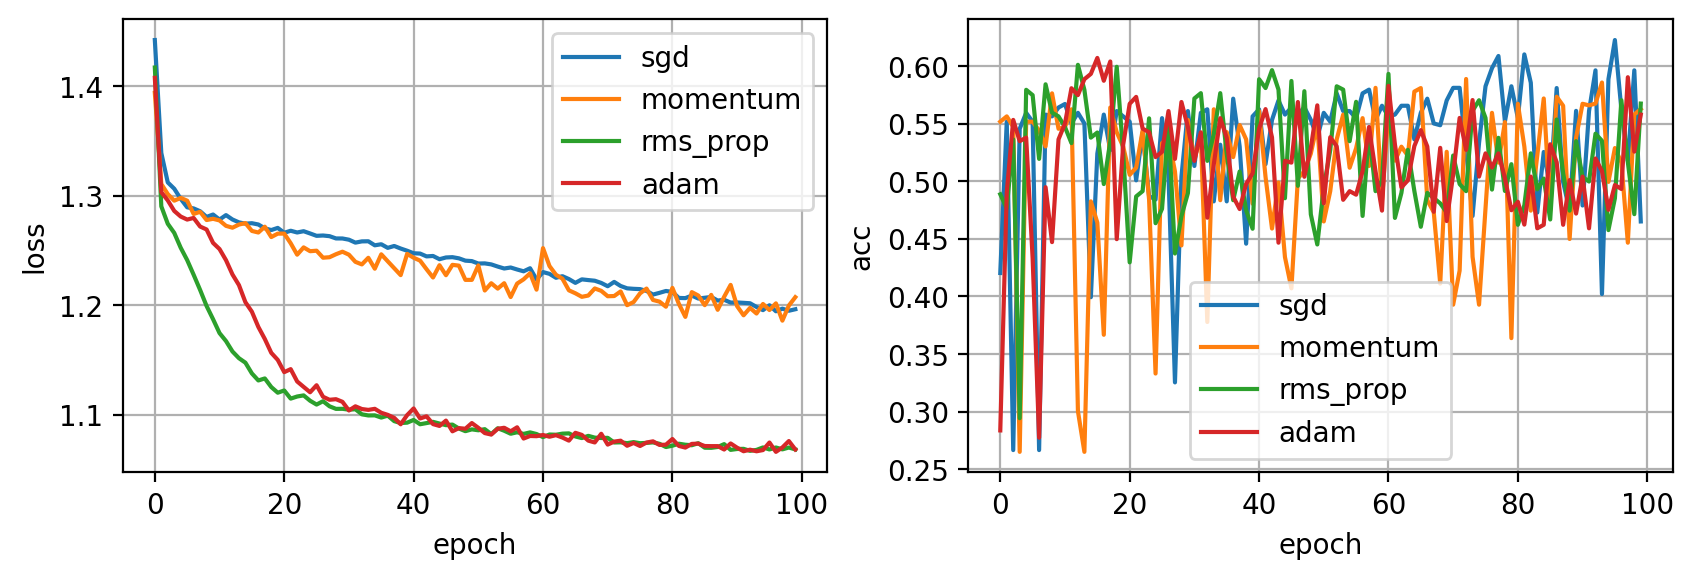

In [38]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_sgd['loss'], label="sgd")
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_rms['loss'], label="rms_prop")
ax.plot(hist_adam['loss'], label="adam")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()